In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# Neural Process 1D - Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Neural Process for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [3]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess
from skssl.predefined import MLP
from skssl.transformers.neuralproc.datasplit import context_target_split

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 128
batch_size = 64 
num_points = 128
num_samples = 100000
n_epochs = 50


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(4, 50),
                                range_extra_trgts=(num_points-50, num_points-50))


def get_model(x_dim, y_dim):
    return NeuralProcess(x_dim, y_dim,
                         Encoder=_DeepMLP,
                         Decoder=_DeepMLP,
                         r_dim=r_dim,
                         LatentEncoder=MLP,
                         get_cntxt_trgt=get_cntxt_trgt,
                        encoded_path="latent")


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))
data_models["periodic"] = (get_model(x_dim, y_dim),
                           GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                                 periodicity=3.0,
                                                                 length_scale_bounds=(0.1, 10.0),
                                                                 periodicity_bounds=(1.0, 10.0)),
                                     num_samples=num_samples,
                                     num_points=num_points))
data_models["non-stationary"] = (get_model(x_dim, y_dim),
                                 GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                                   (DotProduct(sigma_0=1.0,
                                                               sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                           num_samples=num_samples,
                                           num_points=num_points))
data_models["matern"] = (get_model(x_dim, y_dim),
                         GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                       length_scale_bounds=(1e-1, 10.0),
                                                       nu=1.5),
                                   num_samples=num_samples,
                                   num_points=num_points))

/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/master/skssl/predefined/mlp.py:52: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


##  Data

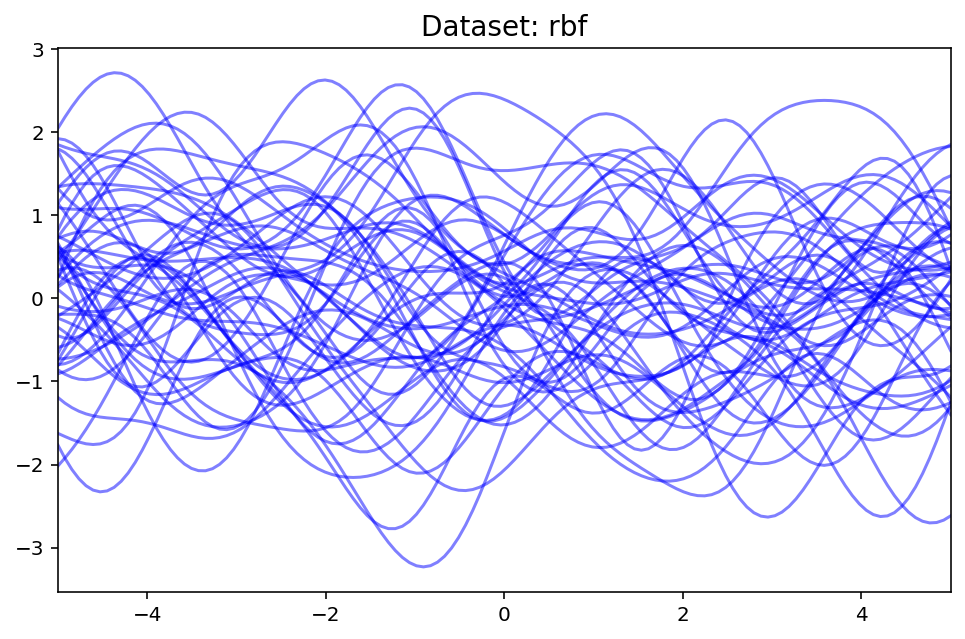

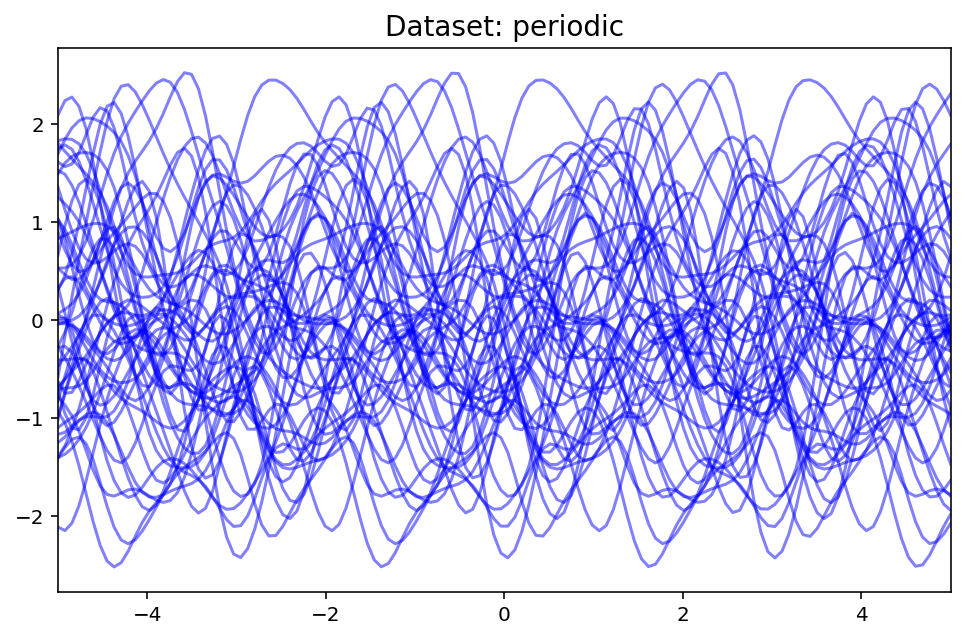

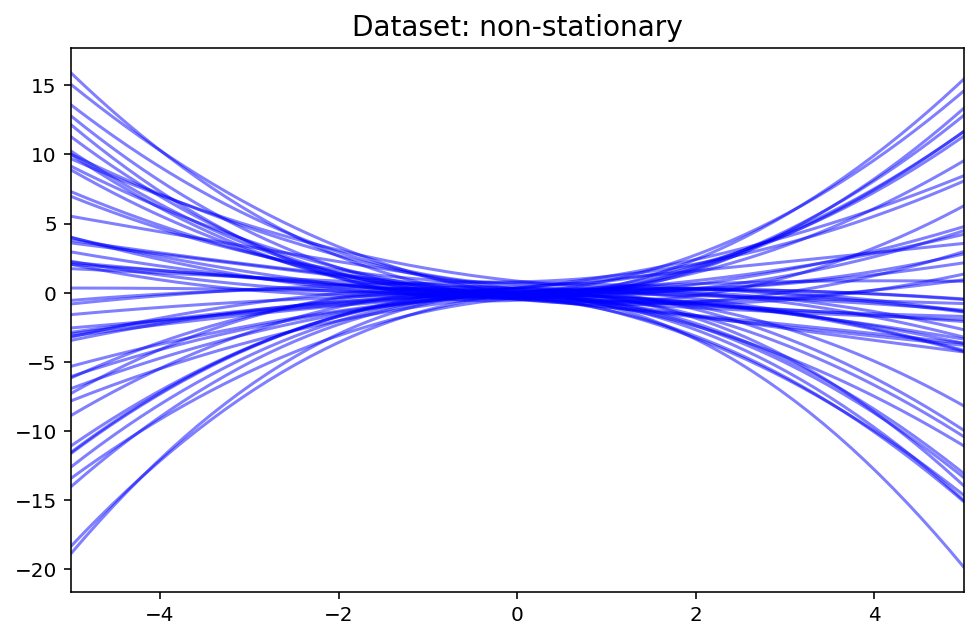

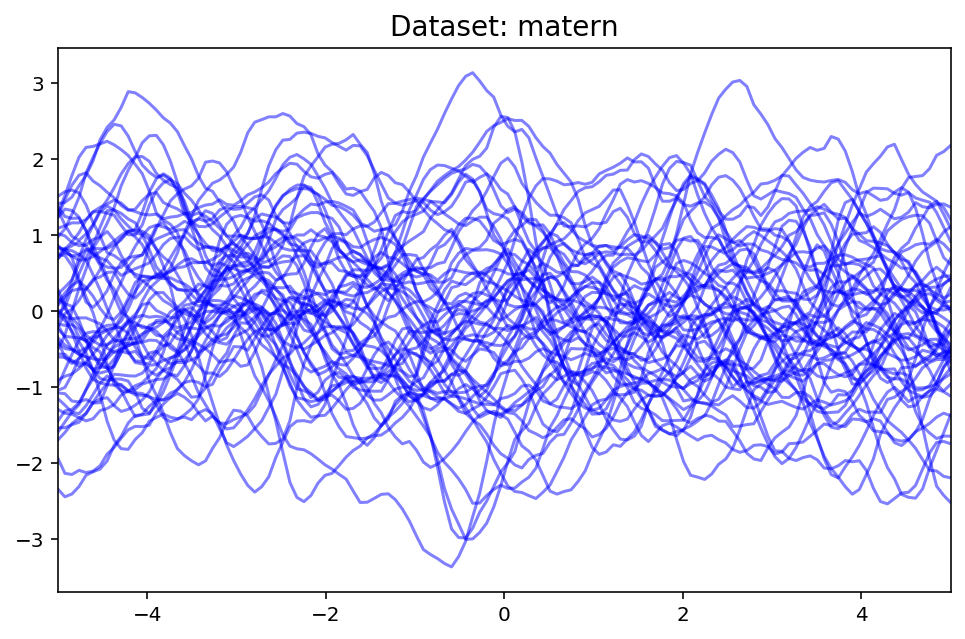

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

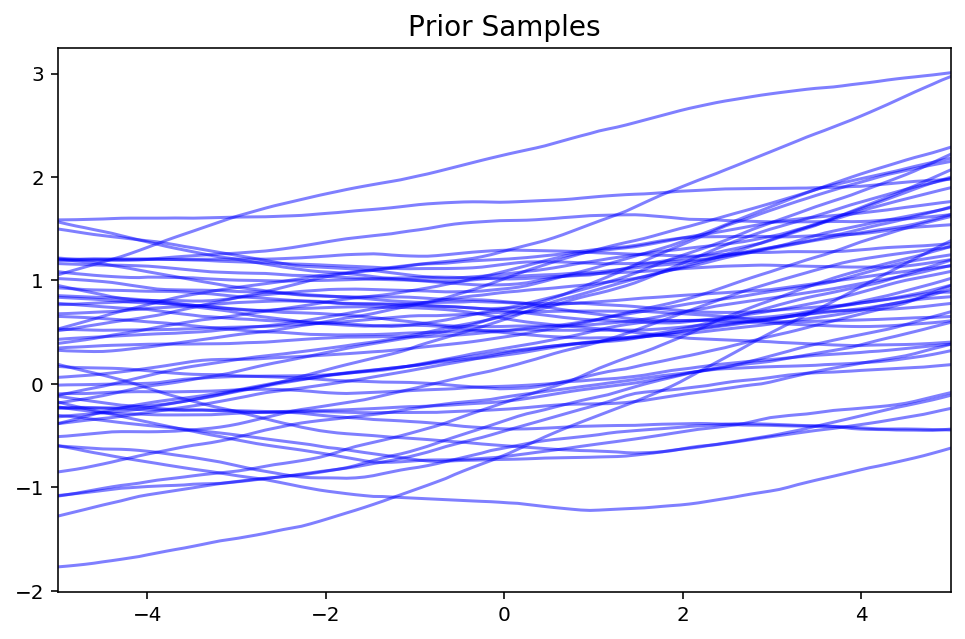

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                train_split=None)  # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss      dur
-------  ------------  -------
      1      262.2941  20.3523


      2      132.4543  20.2526


      3      117.0670  16.2702


      4      106.2951  19.5295


      5       90.1466  19.2696


      6       75.7324  19.6564


      7       58.8336  19.1581


      8       41.0062  21.2031


      9       26.7708  19.7379


     10       11.3532  19.6248


     11       -1.2929  20.7514


     12      -15.8177  17.5769


     13      -25.9949  19.7688


     14      -34.4332  18.7159


     15      -43.3736  20.4333


     16      -52.7917  20.3269


     17      -59.6364  20.4694


     18      -66.1223  19.7954


     19      -69.6418  20.3515


     20      -73.2751  19.8230


     21      -76.6131  19.8695


     22      -79.0012  19.9378


     23      -79.5029  21.7939


     24      -81.6155  19.9972


     25      -84.1462  18.7399


     26      -85.8218  19.9910


     27      -85.3771  19.7962


     28      -86.6135  14.3435


     29      -86.9502  19.2358


     30      -88.7526  19.8520


     31      -94.3817  20.3927


     32      -97.3944  16.1461


     33      -99.8530  15.1778


     34      -99.0418  19.5431


     35     -101.9379  19.9012


     36     -103.0509  20.5467


     37     -103.3018  19.8530


     38     -101.9801  19.4884


     39     -104.3542  20.3021


     40     -105.2985  19.8245


     41     -105.5770  21.1227


     42     -106.2934  19.4027


     43     -105.4075  19.8254


     44     -107.0036  20.1296


     45     -107.0838  19.6021


     46     -107.6981  19.6756


     47     -109.0428  20.5601


     48     -110.8346  19.0987


     49     -112.5433  15.3566


     50     -112.6375  18.4009

--- Training periodic ---



  epoch    train_loss      dur
-------  ------------  -------
      1      137.8989  18.9063


      2      129.6003  19.0874


      3      128.7134  19.7698


      4      128.2233  20.1959


      5      127.6969  19.2990


      6      127.3742  19.6274


      7      127.1365  20.0492


      8      126.6327  17.2428


      9      121.9893  19.7377


     10       90.9191  17.7145


     11       59.7326  20.6490


     12       53.5719  20.0178


     13       49.2339  19.5861


     14       41.1894  18.3876


     15       33.6598  19.9693


     16       30.1382  19.5720


     17       27.9029  17.8053


     18       25.6270  19.9234


     19       24.1887  20.0495


     20       22.9521  20.0236


     21       20.9752  14.9713


     22       19.4564  22.8202


     23       18.6531  20.5212


     24       16.6143  19.0390


     25       14.7543  19.4627


     26        5.3922  20.6836


     27       -0.5668  20.0497


     28       -4.8550  20.0487


     29       -8.5148  18.1414


     30      -10.8972  20.0823


     31      -14.0099  18.7882


     32      -16.1599  19.7104


     33      -17.9968  20.0480


     34      -19.7698  19.9511


     35      -20.6796  19.9773


     36      -22.0501  19.9364


     37      -23.1030  18.6225


     38      -24.2451  20.2705


     39      -25.1550  19.9988


     40      -26.0878  15.3314


     41      -27.2614  18.7500


     42      -28.6202  20.0795


     43      -31.0258  20.4339


     44      -32.5533  19.1224


     45      -33.7584  17.5334


     46      -36.3767  19.2605


     47      -38.1094  20.0071


     48      -40.6122  20.2834


     49      -43.9720  20.1261


     50      -45.9310  18.1475

--- Training non-stationary ---



  epoch    train_loss      dur
-------  ------------  -------
      1      170.2331  19.8312


      2       27.4567  20.2877


      3      -23.0635  19.8972


      4      -46.3906  19.6253


      5      -58.8365  19.9890


      6      -65.4401  19.9604


      7      -73.9965  20.0662


      8      -79.5663  20.3613


      9      -85.6711  17.4913


     10      -91.0558  16.2204


     11      -95.9821  20.3113


     12      -99.8038  17.0781


     13     -104.0484  16.6235


     14     -107.2887  16.8868


     15     -110.5356  19.9380


     16     -113.2880  20.2033


     17     -114.4867  20.0893


     18     -117.3386  18.8595


     19     -120.2989  19.9582


     20     -122.2813  16.3578


     21     -124.3157  12.1141


     22     -127.3598  11.9811


     23     -127.1274  11.9833


     24     -129.1931  12.0441


     25     -129.0525  18.3532


     26     -131.3154  17.0055


     27     -133.2131  11.9938


     28     -131.6765  18.5063


     29     -134.6583  20.6615


     30     -134.9760  20.5324


     31     -133.8387  12.0155


     32     -136.5950  12.0049


     33     -137.0527  13.1066


     34     -137.0128  19.4453


     35     -138.0090  12.0311


     36     -138.3911  12.0820


     37     -139.1263  12.0316


     38     -138.8684  12.0446


     39     -138.8383  18.2062


     40     -139.8244  19.9681


     41     -140.3478  12.1071


     42     -141.3137  12.0517


     43     -140.6534  12.0563


     44     -141.5592  17.2928


     45     -141.0434  12.0802


     46     -142.4980  12.0869


     47     -142.0731  15.3948


     48     -143.0838  20.4703


     49     -142.5846  20.5359


     50     -143.4087  20.4344

--- Training matern ---



  epoch    train_loss      dur
-------  ------------  -------
      1      148.4443  20.6100


      2      115.4131  20.6610


      3       99.3210  20.6908


      4       88.1916  20.5439


      5       80.1243  20.5880


      6       72.1555  20.7458


      7       64.2442  15.4405


      8       57.9608  11.9731


      9       51.2804  16.3297


     10       44.2576  20.5893


     11       38.1107  15.6941


     12       32.6053  20.6765


     13       30.2704  20.8954


     14       28.2585  20.7306


     15       26.1725  20.6072


     16       24.2539  20.5880


     17       22.8358  20.3508


     18       21.9712  20.3514


     19       21.6466  20.6245


     20       18.6440  20.5621


     21       16.4343  20.5696


     22       14.2730  20.3894


     23       13.0713  20.5954


     24       12.0292  19.1579


     25       12.1758  20.6536


     26       11.0314  20.2304


     27       10.8477  20.5871


     28       11.0115  21.0238


     29       10.8987  18.8410


     30       10.4314  17.8837


     31        9.7817  18.8116


     32        9.4518  18.7352


     33        9.6194  19.5139


     34        9.4099  19.4651


     35        8.9759  20.5018


     36        8.7635  18.0516


     37        8.3545  20.4849


     38        8.8246  19.3363


     39        8.1673  20.5191


     40        8.2769  20.7434


     41        8.1386  18.5595


     42        7.7683  20.4972


     43        7.7886  20.3141


     44        7.7328  18.7676


     45        7.4665  20.5032


     46        7.4851  20.0331


     47        7.0228  18.8884


     48        7.3370  21.3953


     49        7.2457  21.8145


     50        6.6401  18.8648


## Trained Prior 
The prior should now encode some information about the shapes of the functions.

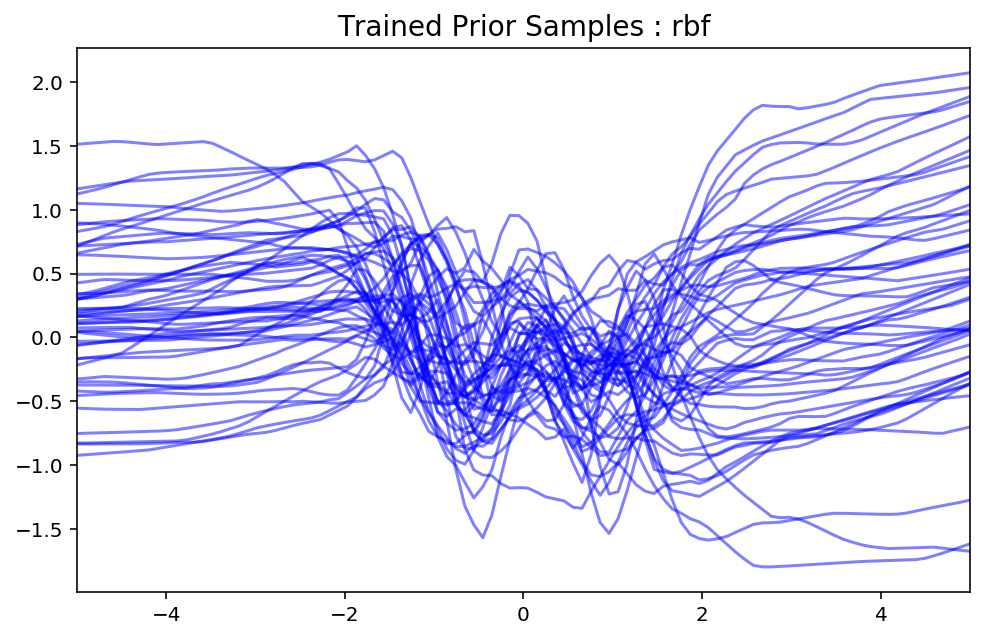

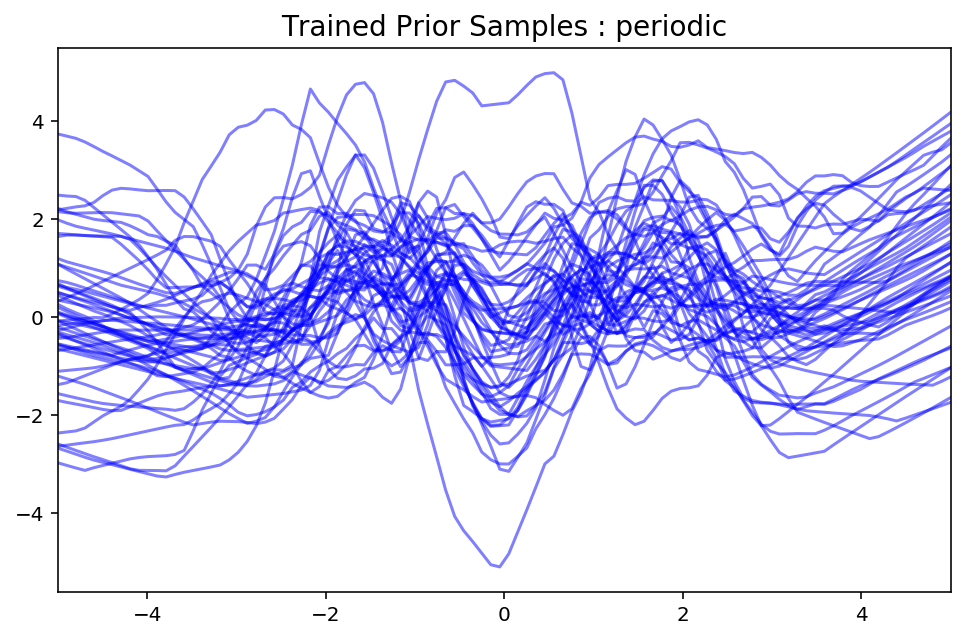

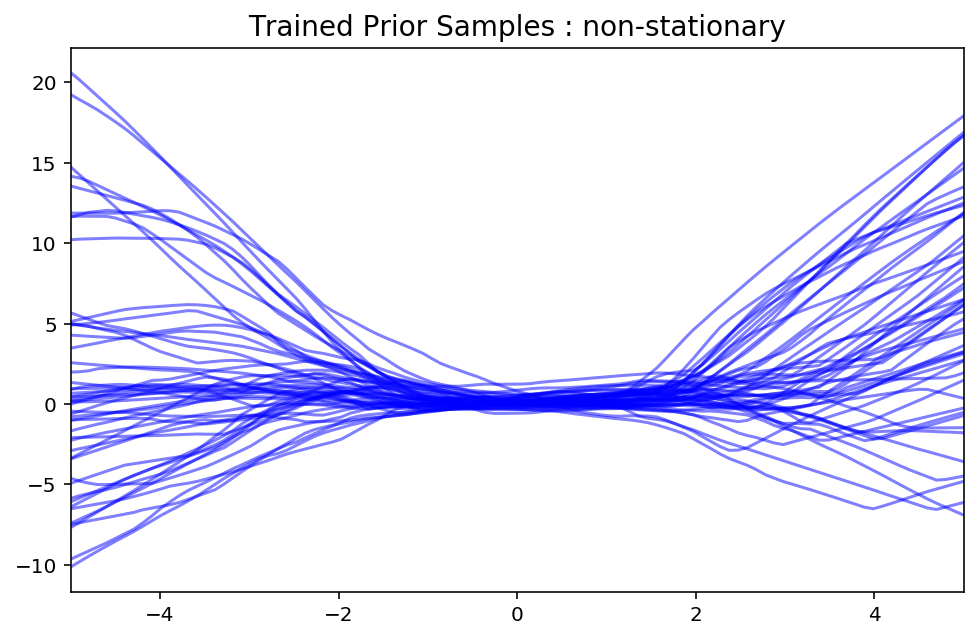

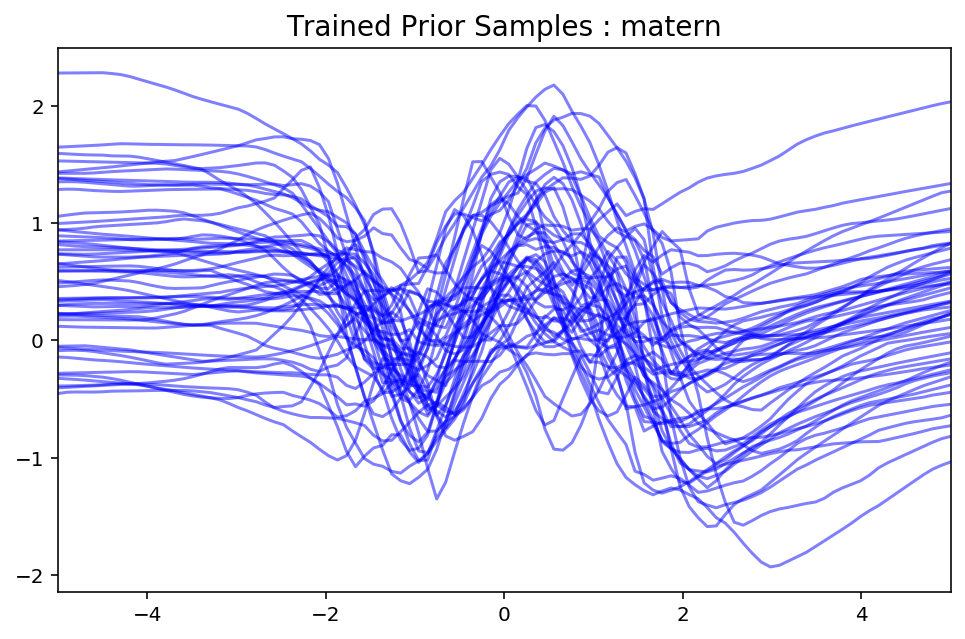

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k))

## Posterior

std: 0.30693477
std: 0.18786742
std: 0.10563877
std: 0.22285374


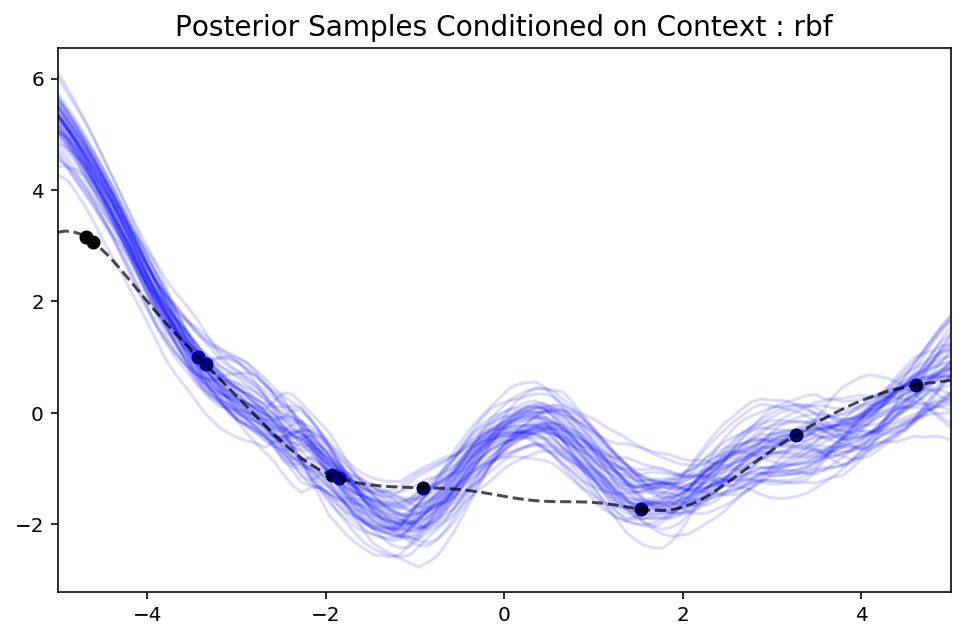

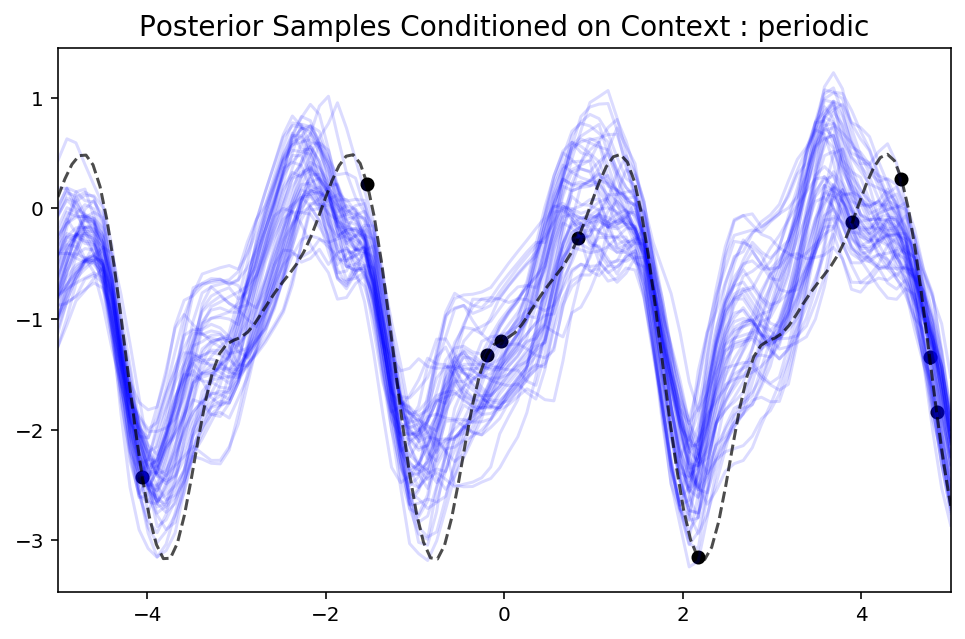

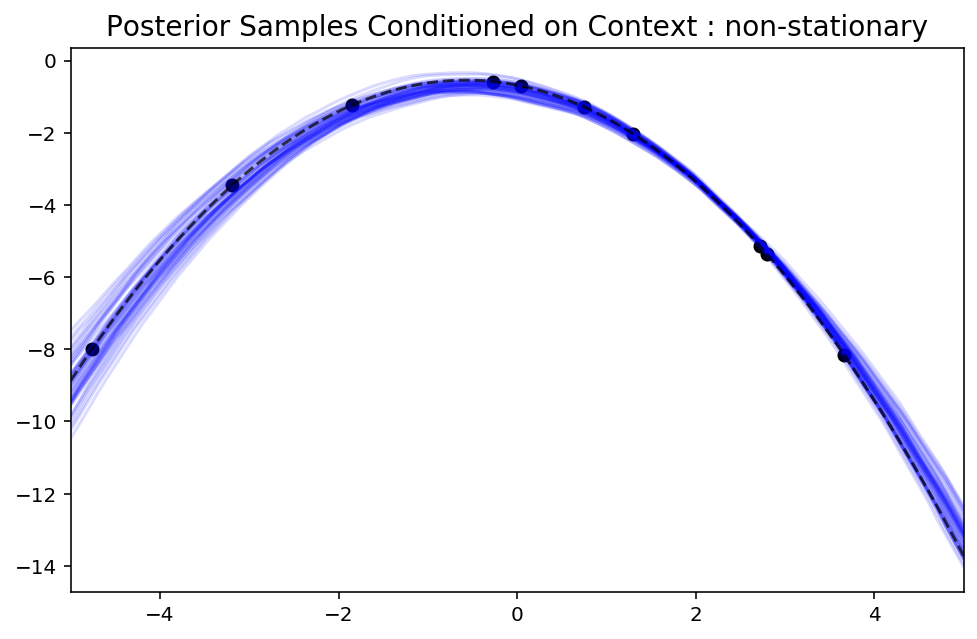

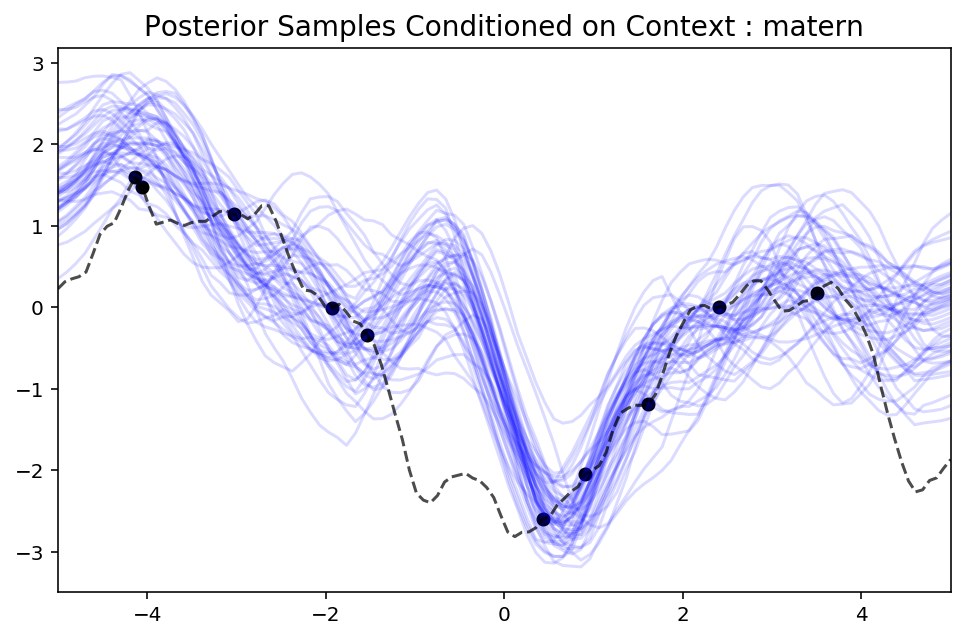

In [9]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),
                           title="Posterior Samples Conditioned on Context : {}".format(k))

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 0.10003976
std: 0.23306389
std: 0.10000003
std: 0.29551885


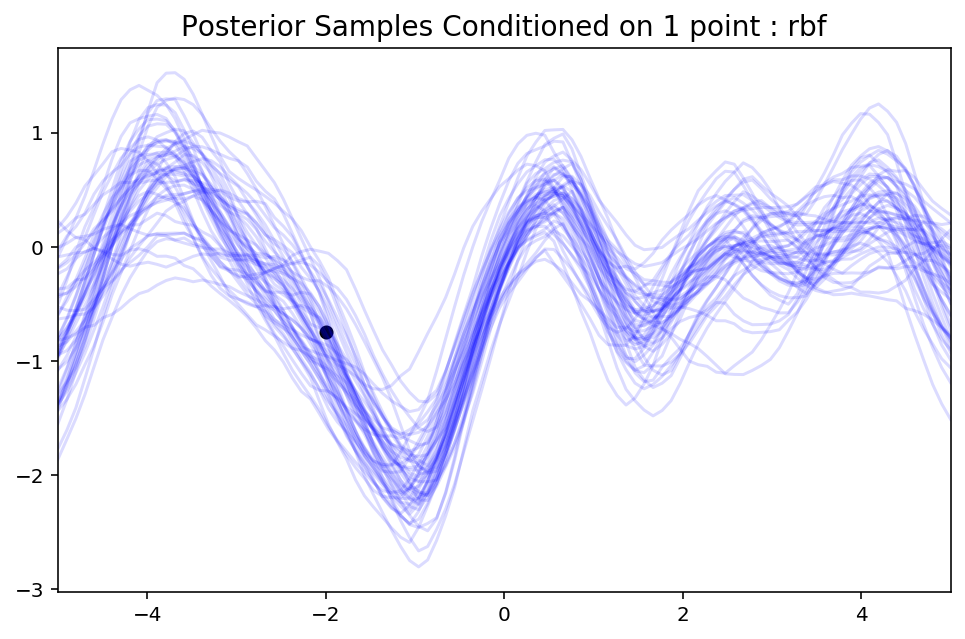

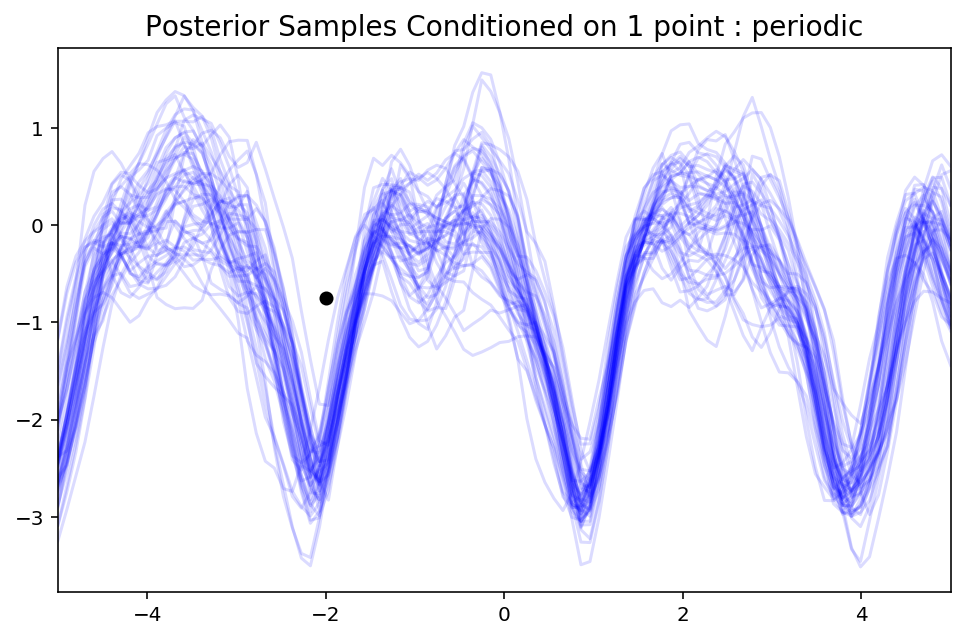

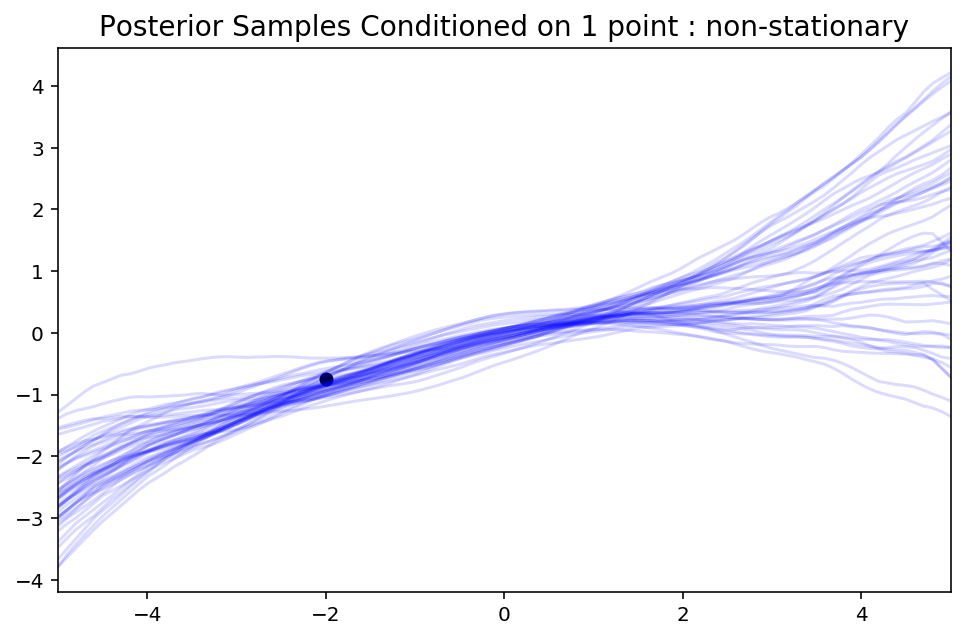

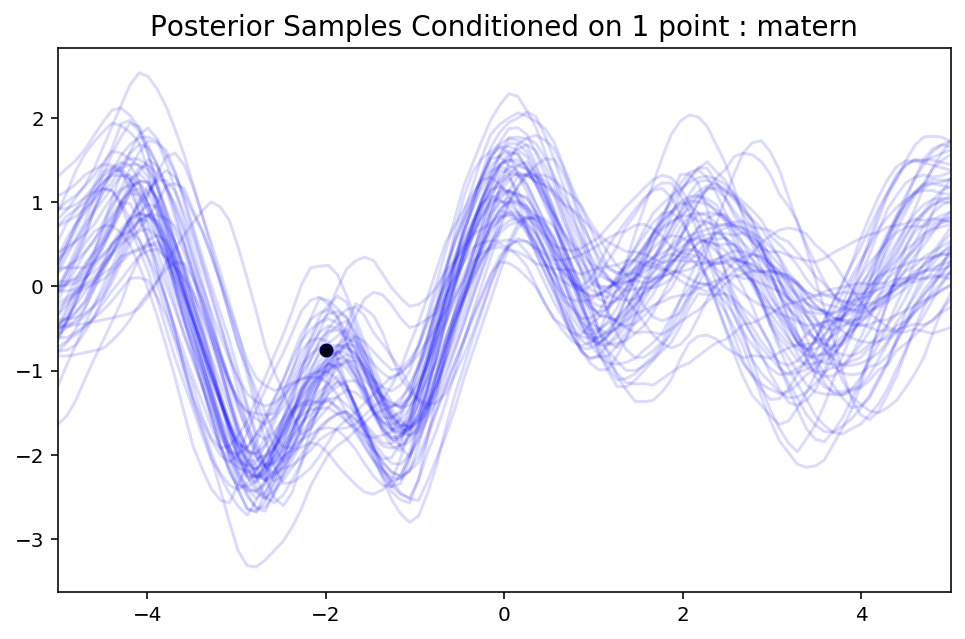

In [10]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

std: 0.10112927
std: 0.34497443
std: 0.10000045
std: 0.23594871


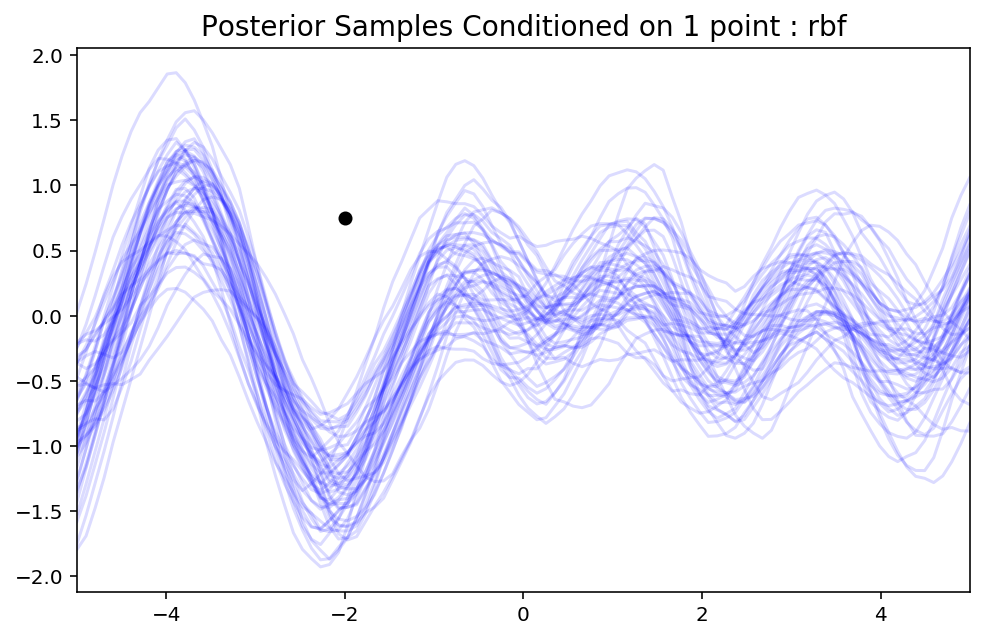

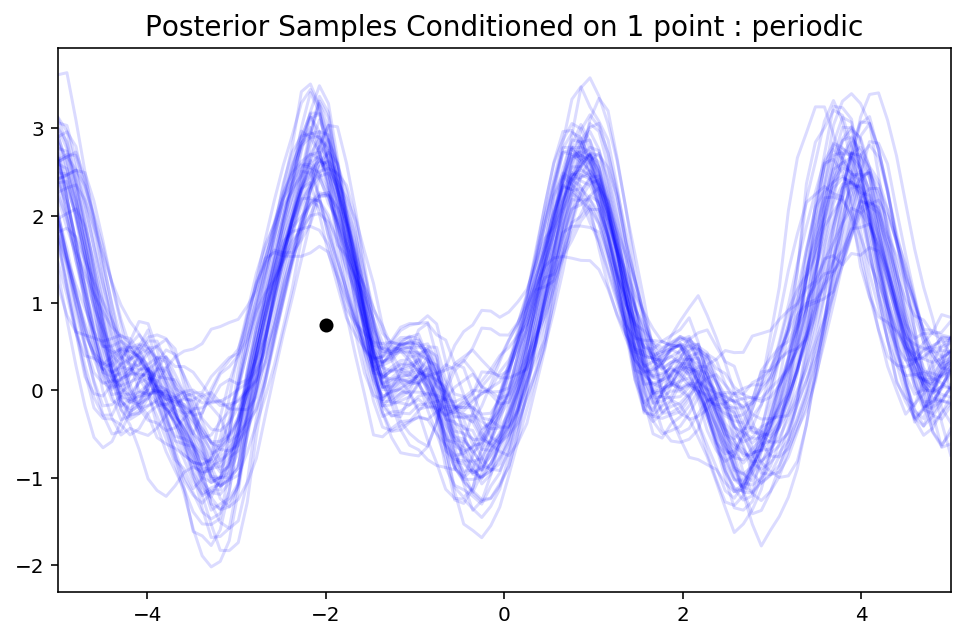

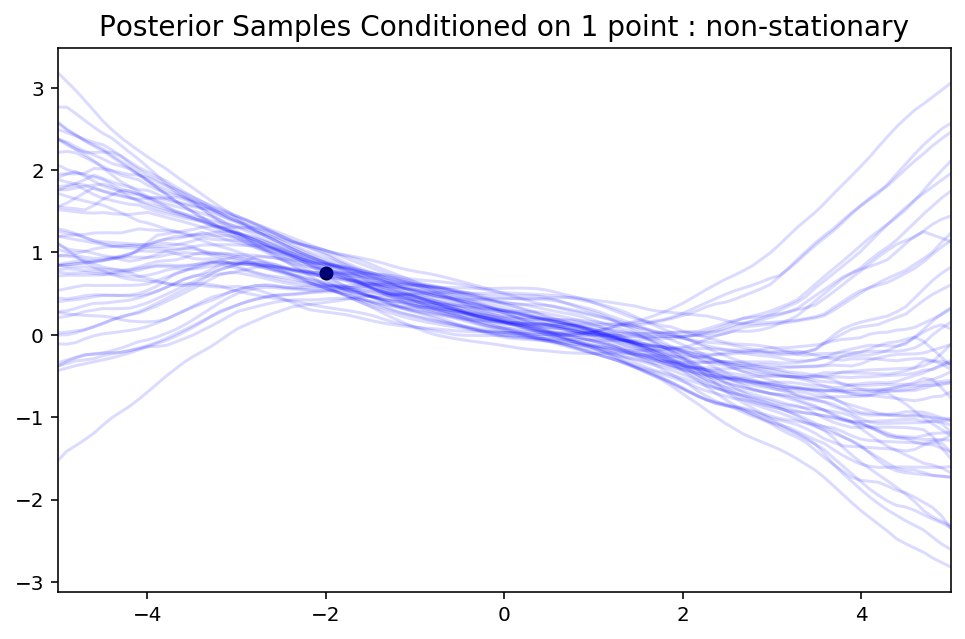

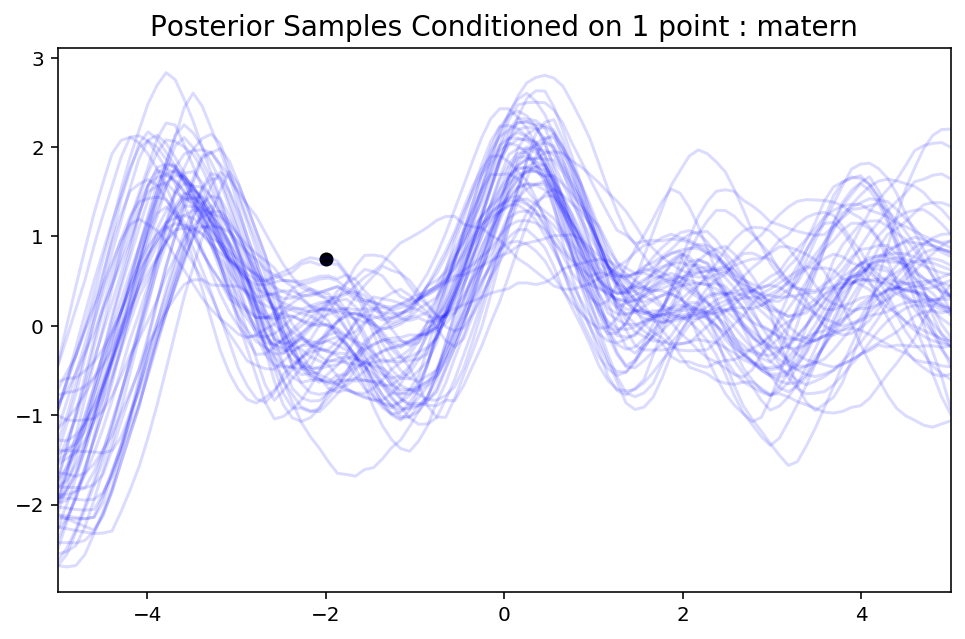

In [11]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]), 
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))